In [7]:
TRAIN_COMPLETE_DATASET = True # Set False to try training on a sample fo the dataset
MICROARCHITECTURES = ["HSW", "IVB", "SKL"]
SELECTED_MICROARCHITECTURE = MICROARCHITECTURES[2]

In [2]:
import torch
import re
import os
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [119]:
def transform_xml(block: str):
    block = block.removeprefix("<block>").removesuffix("</block>")
    instructions = [
        instruction.removesuffix("</instr>")
        for instruction in block.split("<instr>")
        if instruction != ""
    ]
    instructions = [
        [code for code in re.split(r"[<>]", instruction) if code != ""]
        for instruction in instructions
    ]
    return instructions

def prepare_data(data):
    y = [data_point[1] for data_point in data if data_point[3] != None]
    X = [transform_xml(data_point[3]) for data_point in data if data_point[3] != None]
    valid_indices = [
        i
        for i, block_data in enumerate(X)
        if block_data and any(instr for instr in block_data)
    ]
    X = [X[i] for i in valid_indices]
    y = [torch.tensor([y[i]], dtype=torch.float32) for i in valid_indices]

    if not TRAIN_COMPLETE_DATASET:
        X = X[:10000]
        y = y[:10000]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    instruction_set = set(
        [word for data_point in X for instruction in data_point for word in instruction]
    )
    vocab_map = {"<PAD>": 0, "<UNK>": 1}
    vocab_counter = 2
    for word in instruction_set:
        if word not in vocab_map:
            vocab_map[word] = vocab_counter
            vocab_counter += 1
    VOCAB_SIZE = len(vocab_map)
    PADDING_IDX = vocab_map["<PAD>"]

    return X_train, X_test, y_train, y_test, vocab_map, VOCAB_SIZE, PADDING_IDX


In [120]:
data = torch.load(f"data/bhive_{SELECTED_MICROARCHITECTURE.lower()}.data")

X_train, X_test, y_train, y_test, vocab_map, VOCAB_SIZE, PADDING_IDX = prepare_data(data)


In [121]:
def token_str_to_id(tokens_list, local_vocab_map):
    return torch.tensor(
        [local_vocab_map.get(token, local_vocab_map["<UNK>"]) for token in tokens_list],
        dtype=torch.long,
    )

class InstructionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def collate_fn(batch):
    block_token_lists_batch = [item[0] for item in batch]
    labels_batch = [item[1] for item in batch]

    max_instr_count = max(len(block) for block in block_token_lists_batch)
    max_instr_count = max(max_instr_count, 1)

    max_token_count = max(
        len(instr_tokens) for block in block_token_lists_batch for instr_tokens in block
    )
    max_token_count = max(max_token_count, 1)

    padded_blocks_ids = torch.full(
        (len(block_token_lists_batch), max_instr_count, max_token_count),
        PADDING_IDX,
        dtype=torch.long,
    )

    actual_instr_counts = torch.tensor(
        [len(block) for block in block_token_lists_batch], dtype=torch.long
    )
    actual_token_counts = torch.zeros(
        (len(block_token_lists_batch), max_instr_count), dtype=torch.long
    )
    for i, block_tokens in enumerate(block_token_lists_batch):
        for j, instr_tokens in enumerate(block_tokens):
            token_ids = token_str_to_id(instr_tokens, vocab_map)
            len_to_copy = len(token_ids)
            padded_blocks_ids[i, j, :len_to_copy] = token_ids[:len_to_copy]
            actual_token_counts[i, j] = len(instr_tokens)

    batched_labels = torch.stack(labels_batch)

    return (
        padded_blocks_ids,
        batched_labels,
        actual_instr_counts,
        actual_token_counts,
    )

In [122]:
train_dataset = InstructionDataset(X_train, y_train)
test_dataset = InstructionDataset(X_test, y_test)

In [123]:
class Ithemal(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, padding_idx_val=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.padding_idx = padding_idx_val

        self.embedding = nn.Embedding(
            self.vocab_size, self.embedding_size, padding_idx=self.padding_idx
        )
        self.token_rnn = nn.LSTM(
            self.embedding_size, self.hidden_size, batch_first=True
        )
        self.instr_rnn = nn.LSTM(self.hidden_size, self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, 1)

    def forward(self, batched_blocks, actual_instr_counts, actual_token_counts):

        device = self.embedding.weight.device
        batch_size, max_instr_count, max_token_count = batched_blocks.shape

        token_ids_flat = batched_blocks.view(
            batch_size * max_instr_count, max_token_count
        )
        embedded_tokens_flat = self.embedding(token_ids_flat)
        token_lengths_flat = actual_token_counts.reshape(-1)
        token_mask = token_lengths_flat > 0
        embedded_tokens_packed = pack_padded_sequence(
            embedded_tokens_flat[token_mask],
            token_lengths_flat[token_mask].cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        _, (h_n_token, _) = self.token_rnn(embedded_tokens_packed)
        instruction_outputs = h_n_token.squeeze(0)
        all_instruction_repr = torch.zeros(
            batch_size * max_instr_count,
            self.hidden_size,
            device=device,
            dtype=instruction_outputs.dtype,
        )
        all_instruction_repr[token_mask] = instruction_outputs
        instruction_repr_batched = all_instruction_repr.view(
            batch_size, max_instr_count, self.hidden_size
        )

        instruction_repr_packed = pack_padded_sequence(
            instruction_repr_batched,
            actual_instr_counts.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )

        _, (h_n_block, _) = self.instr_rnn(instruction_repr_packed)
        block_repr_batched = h_n_block.squeeze(0)

        output = self.linear(block_repr_batched)
        return output

In [124]:
class MAPE_Loss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPE_Loss, self).__init__()
        self.epsilon = epsilon

    def forward(self, y_pred, y_true):
        if y_true.shape != y_pred.shape:
            raise ValueError(
                f"y_true and y_pred must have the same shape, but got {y_true.shape} and {y_pred.shape}"
            )

        absolute_percentage_error = torch.abs(
            (y_true - y_pred) / (y_true + self.epsilon)
        )
        mape = torch.mean(absolute_percentage_error) * 100
        return mape

In [ ]:
def select_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    else:
        return "cpu"

In [126]:
EMBEDDING_SIZE = 256
BATCH_SIZE = 32
HIDDEN_SIZE = 256
LEARNING_RATE = 1e-3
EPOCHS = 10


device = select_device()
print(f"Using device: {device}")
model = Ithemal(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, PADDING_IDX).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = MAPE_Loss()

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)


Using device: cuda


In [127]:

print(f"Starting batched training with batch_size = {BATCH_SIZE}...")
for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0
    train_batches = 0
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    if len(train_loader) == 0:
        print("Training loader is empty. Skipping training epoch.")
        continue

    for i, (
        batched_block_ids,
        batched_targets,
        actual_instr_counts,
        actual_token_counts,
    ) in enumerate(train_loader):
        batched_block_ids = batched_block_ids.to(device)
        batched_targets = batched_targets.to(device)

        optimizer.zero_grad()
        predictions = model(batched_block_ids, actual_instr_counts, actual_token_counts)
        loss = criterion(predictions, batched_targets)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        train_batches += 1

        print(
            f"\rTraining: Batch {i+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}",
            end="",
        )

    avg_train_loss = total_train_loss / train_batches
    print(f"\rEpoch {epoch+1} Average Training Loss: {avg_train_loss:.4f}            ")

    model.eval()
    total_test_loss = 0
    test_batches = 0

    if len(test_loader) == 0:
        print("Test loader is empty. Skipping evaluation epoch.")
        continue

    with torch.no_grad():
        for i, (
            batched_block_ids,
            batched_targets,
            actual_instr_counts,
            actual_token_counts,
        ) in enumerate(test_loader):
            batched_block_ids = batched_block_ids.to(device)
            batched_targets = batched_targets.to(device)

            predictions = model(
                batched_block_ids, actual_instr_counts, actual_token_counts
            )
            loss = criterion(predictions, batched_targets)
            total_test_loss += loss.item()
            test_batches += 1

            print(
                f"\rTesting: Batch {i+1}/{len(test_loader)}, Batch Loss: {loss.item():.4f}",
                end="",
            )

    avg_test_loss = total_test_loss / test_batches
    print(f"\rEpoch {epoch+1} Average Test Loss: {avg_test_loss:.4f}              ")

print("\nTraining finished.")

Starting batched training with batch_size = 32...

Epoch 1/10
Epoch 1 Average Training Loss: 25.9933            
Epoch 1 Average Test Loss: 16.4776              

Epoch 2/10
Epoch 2 Average Training Loss: 14.9311            
Epoch 2 Average Test Loss: 14.2492              

Epoch 3/10
Epoch 3 Average Training Loss: 13.6500            
Epoch 3 Average Test Loss: 13.5205              

Epoch 4/10
Epoch 4 Average Training Loss: 12.9589            
Epoch 4 Average Test Loss: 12.9383              

Epoch 5/10
Epoch 5 Average Training Loss: 12.5436            
Epoch 5 Average Test Loss: 12.5807              

Epoch 6/10
Epoch 6 Average Training Loss: 12.2395            
Epoch 6 Average Test Loss: 12.3462              

Epoch 7/10
Epoch 7 Average Training Loss: 11.9873            
Epoch 7 Average Test Loss: 12.1018              

Epoch 8/10
Epoch 8 Average Training Loss: 11.7983            
Epoch 8 Average Test Loss: 11.9970              

Epoch 9/10
Epoch 9 Average Training Loss: 11.6241    

In [128]:
model_save_dir = "models/"
model_filename = f"final_ithemal_model_{SELECTED_MICROARCHITECTURE.lower()}.pth"
model_save_path = os.path.join(model_save_dir, model_filename)

os.makedirs(model_save_dir, exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Final model saved to {model_save_path}")

Final model saved to models/final_ithemal_model_skl.pth


# Below is for testing model accuracy

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import pandas as pd

### Run the below cell only if not continuing straight after training

In [ ]:
EMBEDDING_SIZE = 256
BATCH_SIZE = 32
HIDDEN_SIZE = 256

model_filename = f"final_ithemal_model_{SELECTED_MICROARCHITECTURE.lower()}.pth"
model_save_path = os.path.join(model_save_dir, model_filename)

data = torch.load(f"data/bhive_{SELECTED_MICROARCHITECTURE.lower()}.data")
X_train, X_test, y_train, y_test, vocab_map, VOCAB_SIZE, PADDING_IDX = prepare_data(data)

# Load the model if not using the same trained model
device = select_device()
print(f"Using device: {device}")
if os.path.exists(model_save_path):
    print(f"Loading model from {model_save_path}")
    model = Ithemal(VOCAB_SIZE, EMBEDDING_SIZE, HIDDEN_SIZE, PADDING_IDX)
    model.load_state_dict(torch.load(model_save_path))
    model.to(device)
    model.eval()
    print("Model loaded successfully.")
else:
    print(f"Model file {model_save_path} does not exist.")


def collate_fn(batch):
    block_token_lists_batch = [item[0] for item in batch]
    labels_batch = [item[1] for item in batch]

    max_instr_count = max(len(block) for block in block_token_lists_batch)
    max_instr_count = max(max_instr_count, 1)

    max_token_count = max(
        len(instr_tokens) for block in block_token_lists_batch for instr_tokens in block
    )
    max_token_count = max(max_token_count, 1)

    padded_blocks_ids = torch.full(
        (len(block_token_lists_batch), max_instr_count, max_token_count),
        PADDING_IDX,
        dtype=torch.long,
    )

    actual_instr_counts = torch.tensor(
        [len(block) for block in block_token_lists_batch], dtype=torch.long
    )
    actual_token_counts = torch.zeros(
        (len(block_token_lists_batch), max_instr_count), dtype=torch.long
    )
    for i, block_tokens in enumerate(block_token_lists_batch):
        for j, instr_tokens in enumerate(block_tokens):
            token_ids = token_str_to_id(instr_tokens, vocab_map)
            len_to_copy = len(token_ids)
            padded_blocks_ids[i, j, :len_to_copy] = token_ids[:len_to_copy]
            actual_token_counts[i, j] = len(instr_tokens)

    batched_labels = torch.stack(labels_batch)

    return (
        padded_blocks_ids,
        batched_labels,
        actual_instr_counts,
        actual_token_counts,
    )

# We are only using the test portion of the dataset for evaluation
test_dataset = InstructionDataset(X_test, y_test)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

Using device: cuda
Loading model from models/final_ithemal_model_skl.pth
Model loaded successfully.


### Begin Generating Test Predictions

In [ ]:
all_predictions = []
all_targets = []

with torch.no_grad():
        for i, (
            batched_block_ids,
            batched_targets,
            actual_instr_counts,
            actual_token_counts,
        ) in enumerate(test_loader):
            batched_block_ids = batched_block_ids.to(device)
            batched_targets = batched_targets.to(device)

            predictions = model(
                batched_block_ids, actual_instr_counts, actual_token_counts
            )

            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(batched_targets.cpu().numpy())

            print(f"\rPredicting: Batch {i+1}/{len(test_loader)}", end="")
        print("\nPredictions completed.")

y_actual = np.array(all_targets).flatten()
y_pred = np.array(all_predictions).flatten()

Predicting: Batch 1968/1968
Predictions completed.


### Compute Statistics

In [130]:
# Compute APE, PE, SAPE
def compute_metrics(actual, predicted):
    APE = np.abs(predicted - actual) / np.abs(actual) * 100
    PE = (predicted - actual) / actual * 100
    SAPE = np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2) * 100
    return APE, PE, SAPE

APE, PE, SAPE = compute_metrics(y_actual, y_pred)

# Create DataFrame for easier analysis
df = pd.DataFrame({
    "Microarchitecture": [SELECTED_MICROARCHITECTURE] * len(APE),
    "APE": APE,
    "PE": PE,
    "SAPE": SAPE
})

median_ape = np.median(APE)
median_pe = np.median(PE)
median_sape = np.median(SAPE)

skew_ape = pd.Series(APE).skew()
skew_pe = pd.Series(PE).skew()
skew_sape = pd.Series(SAPE).skew()

summary_stats = df.describe()
extra_stats = pd.DataFrame({
    "APE": [median_ape, skew_ape],
    "PE": [median_pe, skew_pe],
    "SAPE": [median_sape, skew_sape]
}, index=["median", "skew"])

summary_stats = pd.concat([summary_stats, extra_stats])


os.makedirs("models/evaluation/", exist_ok=True)
np.savetxt(f"models/evaluation/{SELECTED_MICROARCHITECTURE}_APE.csv", APE, delimiter=",", fmt="%f")
np.savetxt(f"models/evaluation/{SELECTED_MICROARCHITECTURE}_PE.csv", PE, delimiter=",", fmt="%f")
np.savetxt(f"models/evaluation/{SELECTED_MICROARCHITECTURE}_SAPE.csv", SAPE, delimiter=",", fmt="%f")
summary_stats.to_csv(f"models/evaluation/summary_statistics_{SELECTED_MICROARCHITECTURE.lower()}.csv")
print("Statistics saved to models/evaluation/")

print(f"Summary Statistics for {SELECTED_MICROARCHITECTURE}:")
print(summary_stats)


Statistics saved to models/evaluation/
Summary Statistics for SKL:
                 APE            PE          SAPE
count   62976.000000  62976.000000  62976.000000
mean       11.732327     -6.275290     15.029927
std        23.033705     25.076260     30.548414
min         0.000071    -99.793091      0.000071
25%         1.457230     -6.518991      1.456678
50%         4.091971     -0.216131      4.073283
75%        11.053051      2.824237     11.122023
max      2990.619141   2990.619141    199.174057
median      4.091970     -0.216131      4.073283
skew       36.313301     26.233376      3.196921


### Generate visualizations
Make sure to run the evaluations for all microarchitectures before generating visualizations

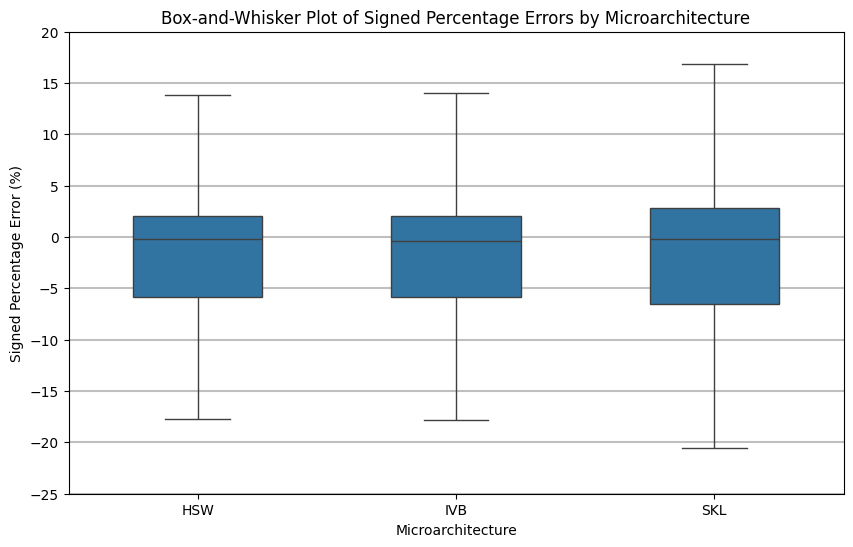

In [8]:
# Load CSV files
PE_HSW = np.loadtxt(f"models/evaluation/{MICROARCHITECTURES[0]}_PE.csv", delimiter=",")
PE_IVB = np.loadtxt(f"models/evaluation/{MICROARCHITECTURES[1]}_PE.csv", delimiter=",")
PE_SKL = np.loadtxt(f"models/evaluation/{MICROARCHITECTURES[2]}_PE.csv", delimiter=",")


df = pd.DataFrame({
    "Microarchitecture": ["HSW"] * len(PE_HSW) + ["IVB"] * len(PE_IVB) + ["SKL"] * len(PE_SKL),
    "Signed Percentage Error": np.concatenate([PE_HSW, PE_IVB, PE_SKL])
})

# Generate Box-and-Whisker Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x="Microarchitecture", y="Signed Percentage Error", data=df, showfliers=False, width=0.5)
plt.title("Box-and-Whisker Plot of Signed Percentage Errors by Microarchitecture")
plt.ylim(-25, 20)
increment = 5
for y in np.arange(-25, 20 + increment, increment):
    plt.axhline(y=y, color="gray", linestyle="-", alpha=0.5, zorder=0)

plt.ylabel("Signed Percentage Error (%)")
plt.xlabel("Microarchitecture")
plt.show()



In [9]:
PE_HSW_arcsinh = np.arcsinh(PE_HSW)
PE_IVB_arcsinh = np.arcsinh(PE_IVB)
PE_SKL_arcsinh = np.arcsinh(PE_SKL)

In [10]:
def sinh_formatter(x_arcsinh, pos):
    return f"{np.sinh(x_arcsinh):.2f}"

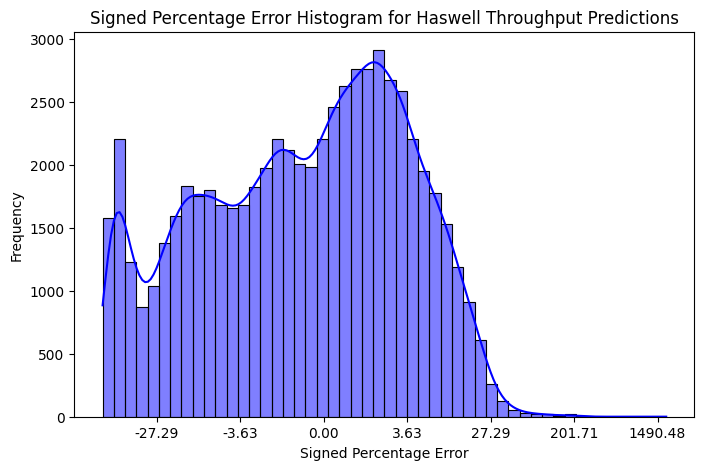

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(PE_HSW_arcsinh, bins=50, kde=True, color="blue")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(sinh_formatter))
ax.set_title("Signed Percentage Error Histogram for Haswell Throughput Predictions")
ax.set_xlabel("Signed Percentage Error")
ax.set_ylabel("Frequency")
plt.show()

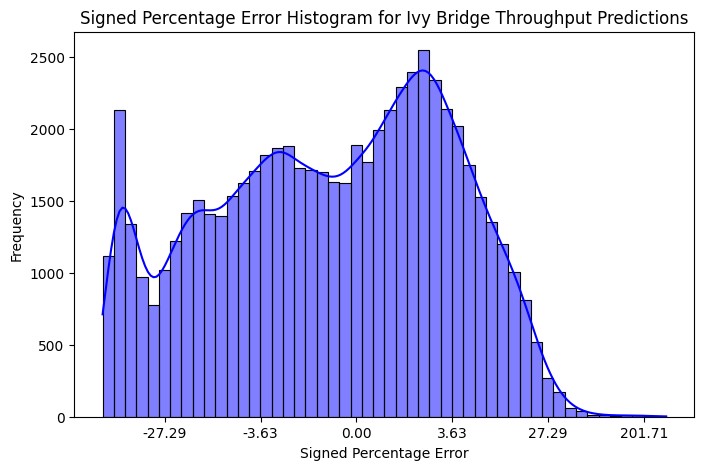

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(PE_IVB_arcsinh, bins=50, kde=True, color="blue")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(sinh_formatter))
ax.set_title(
    "Signed Percentage Error Histogram for Ivy Bridge Throughput Predictions"
)
ax.set_xlabel("Signed Percentage Error")
ax.set_ylabel("Frequency")
plt.show()

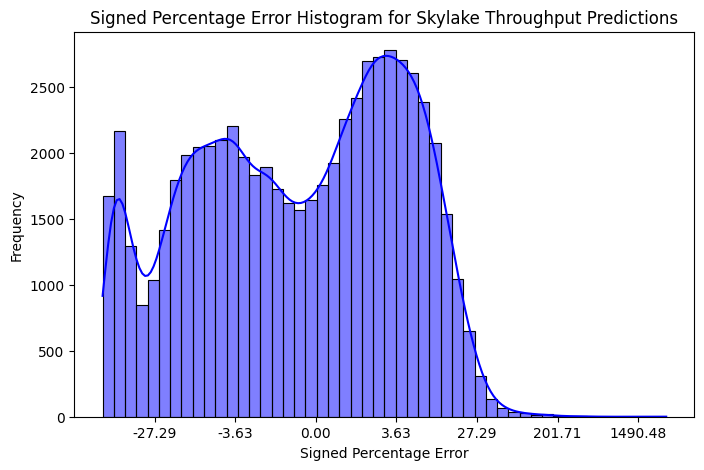

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(PE_SKL_arcsinh, bins=50, kde=True, color="blue")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(sinh_formatter))
ax.set_title(
    "Signed Percentage Error Histogram for Skylake Throughput Predictions"
)
ax.set_xlabel("Signed Percentage Error")
ax.set_ylabel("Frequency")
plt.show()